In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.special as ScSc
from tqdm import tqdm


In [3]:
def LSE(X):
    x_max = max(X)
    diff = [math.exp(x-x_max) for x in X]
    sum = x_max + math.log(np.sum(diff))

    return sum


In [4]:
class GMM:
    """
    Diagonal Gaussian Mixture Model
    """

    def __init__(self, k, d, sigma_init = 0.1):
        self.num_cluster = k
        self.x_dim = d
        self.weights = ScSc.softmax(np.random.normal(scale = sigma_init, size=(k,)))
        self.means = np.random.normal(scale = sigma_init, size =(k, d))
        self.sigmas = np.random.lognormal(sigma=sigma_init, size=(k, d)) # All positive
    
    def EM(self, X, max_iter = 500, tol = 1e-5, eps = 1e-10):
        """
        EM Step
        """
        assert X.ndim == 2
        n = X.shape[0]
        assert X.shape[1] == self.x_dim

        loss_hist = []
        rlog = np.zeros((n, self.num_cluster))
        r = np.zeros((n, self.num_cluster))
        for it in (range(max_iter)):
            ###########
            # E Step
            ###########
            for k in range(self.num_cluster):

                # Updating rik
                partition = np.log(self.weights[k]+eps) - 0.5*np.log(self.sigmas[k, :]+eps).sum()
                s = 1/ (self.sigmas[k, :] + eps)
                delta = X - self.means[k][np.newaxis, :]
                exp_term = np.sum(delta * delta * s[np.newaxis, :], axis = -1)
                rlog[:, k] = -0.5 * exp_term + partition

            # Normalize
            rlogsum = []
            for i in range(n):
                ri_log = LSE(rlog[i])
                rlogsum.append(ri_log)
            rlogsum = np.array(rlogsum)
            assert rlogsum.shape == (n,)
            rlogsum = np.array(rlogsum)
            rlog = rlog - rlogsum[:, np.newaxis]
            loss = -np.sum(rlogsum)
            loss_hist.append(loss)

            
            # Convert back to exp form
            for i in range(n):
                for k in range(self.num_cluster):
                    r[i, k] = np.exp(rlog[i, k])
            
            if it > 0 and abs(loss_hist[-1] - loss_hist[-2]) <= tol * abs(loss_hist[-1]):
                break

            ###########
            # M Step
            ###########
            rsum = np.sum(r, axis = 0)
            assert rsum.shape == (self.num_cluster,)
            self.weights = rsum/n

            for k in range(self.num_cluster):
                self.means[k, :] = np.sum(r[:, k, np.newaxis] * X, axis = 0) / (rsum[k] + eps)
                self.sigmas[k, :] = np.sum(r[:, k, np.newaxis] * X * X, axis = 0) / (rsum[k] + eps) - self.means[k, :] * self.means[k, :]

        return loss_hist
    
    def sort_weights(self):
        """
        Sort the parameters according to their weights
        """
        order = np.argsort(self.weights)[::-1]
        self.weights = self.weights[order]
        self.means = self.weights[order]
        self.sigmas = self.sigmas[order]
    
    def posterior(self, x):
        eps = 1e-8
        p = 0
        for k in range(self.num_cluster):
            det = (2*math.pi) ** 20 * np.prod(self.sigmas[k])
            s = 1/ (self.sigmas[k, :] + eps)
            delta = x - self.means[k]
            exp_term = -0.5 * np.sum(delta * delta * s[np.newaxis, :], axis = -1)
            prob = 1/math.sqrt(det+eps) * math.exp(exp_term)
            p += self.weights[k]*prob
        return p
    
    # def pdf(self, x):
    #     assert x.ndim == 2
    #     n = x.shape[0]
    #     assert x.shape[1] == self.x_dim
        
    #     r = np.zeros((n,self.num_cluster))
    #     for j in range(self.num_cluster):
    #         partition = np.log(self.weights[j]) - 0.5 * np.log(self.sigmas[j,:]).sum()
            
    #         s = 1 / self.sigmas[j,:]
    #         form = x - self.means[j][np.newaxis,:]
    #         form = np.sum(form * form * s[np.newaxis,:], axis=-1)
    #         r[:,j] = np.exp(-0.5 * form + partition)
            
    #     return np.sum(r * self.weights[np.newaxis,:], axis=-1)
            

In [5]:
data = np.loadtxt('gmm_dataset.csv', delimiter=",")


FileNotFoundError: gmm_dataset.csv not found.

In [14]:
gmms = []
losses_overk = []
for k in range(1, 11):
    print("Constructing GMM with k =", k)
    gmm = GMM(k, 20)
    loss = gmm.EM(data)
    losses_overk.append(loss[-1])
    gmms.append(gmm)

Constructing GMM with k = 1


  0%|          | 2/500 [00:00<00:52,  9.49it/s]


Constructing GMM with k = 2


  2%|▏         | 8/500 [00:00<00:45, 10.88it/s]


Constructing GMM with k = 3


  2%|▏         | 8/500 [00:00<00:51,  9.60it/s]


Constructing GMM with k = 4


  1%|▏         | 7/500 [00:00<00:58,  8.40it/s]


Constructing GMM with k = 5


  4%|▍         | 19/500 [00:02<00:57,  8.33it/s]


Constructing GMM with k = 6


  4%|▍         | 21/500 [00:02<01:03,  7.54it/s]


Constructing GMM with k = 7


  3%|▎         | 17/500 [00:02<01:09,  6.97it/s]


Constructing GMM with k = 8


  5%|▍         | 24/500 [00:03<01:11,  6.62it/s]


Constructing GMM with k = 9


  5%|▍         | 23/500 [00:03<01:18,  6.06it/s]


Constructing GMM with k = 10


  6%|▌         | 30/500 [00:05<01:22,  5.69it/s]


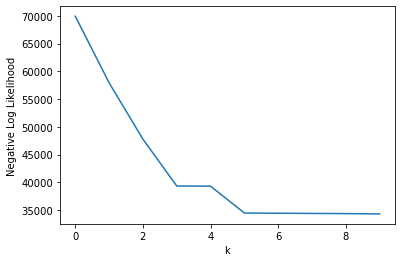

[69939.41787263457, 57942.006972551004, 47786.61744250748, 39346.71943106953, 39315.73555585039, 34473.299038618214, 34438.003370145816, 34401.475560808365, 34370.770511469964, 34313.88642442304]


In [15]:
plt.plot(losses_overk)
plt.ylabel("Negative Log Likelihood")
plt.xlabel("k")
plt.show()
print(losses_overk)



In [16]:
print("Choose k = 5")
chosen_gmm = gmms[4]
chosen_gmm.sort_weights()
print("Weights:")
print(chosen_gmm.weights)
print("Means:")
print(chosen_gmm.means)
print("Covariances:")
print(chosen_gmm.sigmas)

Choose k = 5
Weights:
[0.30022336 0.27397656 0.20005702 0.19967065 0.0260724 ]
Means:
[0.0260724  0.30022336 0.20005702 0.19967065 0.27397656]
Covariances:
[[0.35429505 1.30403135 0.66527093 2.26419023 0.62748894 1.58079236
  1.12668033 0.04878146 0.7546333  1.64247456 1.28763985 0.28287607
  0.04109253 1.10090862 0.51159202 0.16765844 0.78528365 0.77080622
  2.13336222 1.35676643]
 [0.48093666 1.81925181 0.98376408 0.0822583  1.13794652 0.8035962
  0.99268438 1.51284714 1.12706069 0.31278353 0.87930055 0.3341494
  0.73607207 0.6647343  1.07456978 0.6906705  0.76903794 0.67987721
  0.42890608 0.01742112]
 [1.60218982 0.4555183  0.1693725  0.61326473 2.49069343 0.88631456
  0.87429058 1.15516003 1.38452688 0.46607915 0.06871054 1.75239447
  0.75036714 0.79986671 0.10019445 0.67225456 1.12720655 1.03094425
  1.13973957 0.43648493]
 [5.55595937 1.14896613 0.84353182 3.451043   0.97608993 1.14945413
  0.56445548 1.23612491 1.93663672 1.28178067 1.20294932 0.9607868
  1.33793936 2.08702262 

# Using GMM on MNIST

In [6]:
# Import datasets and reduce by PCA
import torch
import numpy as np

import torchvision.datasets as datasets

root = './data'
train_data = datasets.MNIST(root = root, train= True, transform=None, download=True)
test_data = datasets.MNIST(root = root, train= False, transform=None, download=True)

train_X = train_data.data
train_Y = train_data.targets
train_X = np.reshape(train_X, (60000, 784))
test_X = test_data.data
test_Y = test_data.targets
test_X = np.reshape(test_X, (10000, 784))

from sklearn.decomposition import PCA 

d = 40

reducer = PCA(n_components=d)
reducer.fit(train_X)

train_data_reduced = reducer.transform(train_X)
test_data_reduced = reducer.transform(test_X)

label_set = set(train_Y)
train_Y = train_Y.numpy()
test_Y = test_Y.numpy()

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 9912422/9912422 [00:00<00:00, 17274498.93it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27930757.16it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 9366278.43it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5504342.32it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
train_x_split = np.array([[]*10])
print(train_x_split.shape)

(1, 0)


In [8]:
def split_training_set(train_x, train_y):
    train_x_split = [[] for _ in range(10)]
    for i in range(len(train_y)):
        train_x_split[train_y[i]].append(train_x[i])
    return train_x_split

def train_baysianGMM(train_x, train_y, k):
    gmms = []
    d = len(train_x[0])

    train_x_by_classes = split_training_set(train_x, train_y)

    # Calculate P(Y=c)
    total = len(train_x)
    P_yc = []
    for x_c in train_x_by_classes:
        P_yc.append(len(x_c)/total)

    print("------- Training ------")
    # Train gmm for each class
    for c in tqdm(range(len(train_x_by_classes))):
        train_x_class_c = np.array(train_x_by_classes[c])
        gmm_c = GMM(k, d)
        gmm_c.EM(train_x_class_c)
        gmms.append(gmm_c)

    return gmms, P_yc

def baysianGMM_classifier(x, gmms, P_yc):
    largest_prob = -1
    chosen_c = -1
    for c in range(len(gmms)):
        gmm_c = gmms[c]
        prob = gmm_c.posterior(x) * P_yc[c]
        if prob > largest_prob:
            largest_prob = prob
            chosen_c = c
    
    return chosen_c

def report_test_err(test_X, test_Y, gmms, P_yc):
    pred_Y = []
    print("------- Testing ------")
    for x in tqdm(test_X):
        y_hat = baysianGMM_classifier(x, gmms, P_yc)
        pred_Y.append(y_hat)

    err_count = 0
    for y_hat, y in zip(pred_Y, test_Y):
        if y_hat != y:
            err_count += 1
    
    return err_count/len(test_Y)

def train_and_test(train_data, train_label, test_data, test_label):
    err_list = []
    for k in (range(1, 11)):
        print("============= Train and Test for k =", k, "===============")
        gmms, p_yc= train_baysianGMM(train_data, train_label, k)
        err = report_test_err(test_data, test_label, gmms, p_yc)
        err_list.append(err)
        print("For k=", k, "Error is:", err)


    return err_list


In [9]:
# train_and_test(train_data_reduced, train_Y, test_data_reduced, test_Y)
gmms, p_yc= train_baysianGMM(train_data_reduced, train_Y, 5)   
    

------- Training ------


100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


In [10]:
err_list = train_and_test(train_data_reduced, train_Y, test_data_reduced, test_Y)

============= Train and Test for k = 1 ===============
------- Training ------


100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:01<00:00, 5443.89it/s]


For k= 1 Error is: 0.1249
============= Train and Test for k = 2 ===============
------- Training ------


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


------- Testing ------


100%|██████████| 10000/10000 [00:03<00:00, 2754.58it/s]


For k= 2 Error is: 0.108
============= Train and Test for k = 3 ===============
------- Training ------


100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


------- Testing ------


100%|██████████| 10000/10000 [00:06<00:00, 1650.27it/s]


For k= 3 Error is: 0.0979
============= Train and Test for k = 4 ===============
------- Training ------


100%|██████████| 10/10 [00:23<00:00,  2.33s/it]


------- Testing ------


100%|██████████| 10000/10000 [00:07<00:00, 1413.57it/s]


For k= 4 Error is: 0.0909
============= Train and Test for k = 5 ===============
------- Training ------


100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


------- Testing ------


100%|██████████| 10000/10000 [00:08<00:00, 1135.53it/s]


For k= 5 Error is: 0.0838
============= Train and Test for k = 6 ===============
------- Training ------


100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


------- Testing ------


100%|██████████| 10000/10000 [00:10<00:00, 951.35it/s]


For k= 6 Error is: 0.0833
============= Train and Test for k = 7 ===============
------- Training ------


100%|██████████| 10/10 [00:32<00:00,  3.26s/it]


------- Testing ------


100%|██████████| 10000/10000 [00:12<00:00, 798.82it/s]


For k= 7 Error is: 0.0726
============= Train and Test for k = 8 ===============
------- Training ------


100%|██████████| 10/10 [00:41<00:00,  4.20s/it]


------- Testing ------


100%|██████████| 10000/10000 [00:13<00:00, 718.25it/s]


For k= 8 Error is: 0.0711
============= Train and Test for k = 9 ===============
------- Training ------


100%|██████████| 10/10 [00:40<00:00,  4.08s/it]


------- Testing ------


100%|██████████| 10000/10000 [00:15<00:00, 658.49it/s]


For k= 9 Error is: 0.0707
============= Train and Test for k = 10 ===============
------- Training ------


100%|██████████| 10/10 [01:36<00:00,  9.60s/it]


------- Testing ------


100%|██████████| 10000/10000 [00:17<00:00, 579.37it/s]

For k= 10 Error is: 0.0702
